# SCATrEx

Here we generate and run SCATrEx on a small simulated data set consisting of a tree with 3 CNA clones and 1 extra cluster per clone and single-cell gene expression data of 200 cells on 100 genes. We set 5% of the genes to be insensitive do copy number changes in the simulated data, and see how SCATrEx (which doesn't use this information) identifies them. For simplicity and speed, we this tutorial does not use noise factors. Running this tutorial on a common laptop should take about 10 minutes.

In [1]:
import scatrex
from scatrex import models
import scanpy as sc

import matplotlib.pyplot as plt
import numpy as np
import time

## Simulate data

In [2]:
seed = 1

sim_sca = scatrex.SCATrEx(model=models.cna)

observed_tree_args = dict(n_nodes=4, node_weights=np.array([.25, .25, .25, .25]))
observed_tree_params = dict(n_regions=20, min_cn=1, min_nevents=2, max_nevents_frac=.3)
sim_sca.simulate_tree(observed_tree=None, n_extra_per_observed=1, n_genes=100, seed=seed,
                        observed_tree_params=observed_tree_params, observed_tree_args=observed_tree_args)
sim_sca.observed_tree.create_adata()

sim_sca.ntssb.reset_node_parameters(node_hyperparams=dict(log_lib_size_mean=8.1, log_lib_size_std=.6, 
                                                          num_global_noise_factors=0,
                                                          frac_dosage=.95,
                                                          baseline_shape=1.))

sim_sca.simulate_data(n_cells=200, copy=False, seed=seed)

/Users/pedrof/opt/anaconda3/envs/py38/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


... storing 'node' as categorical
... storing 'obs_node' as categorical


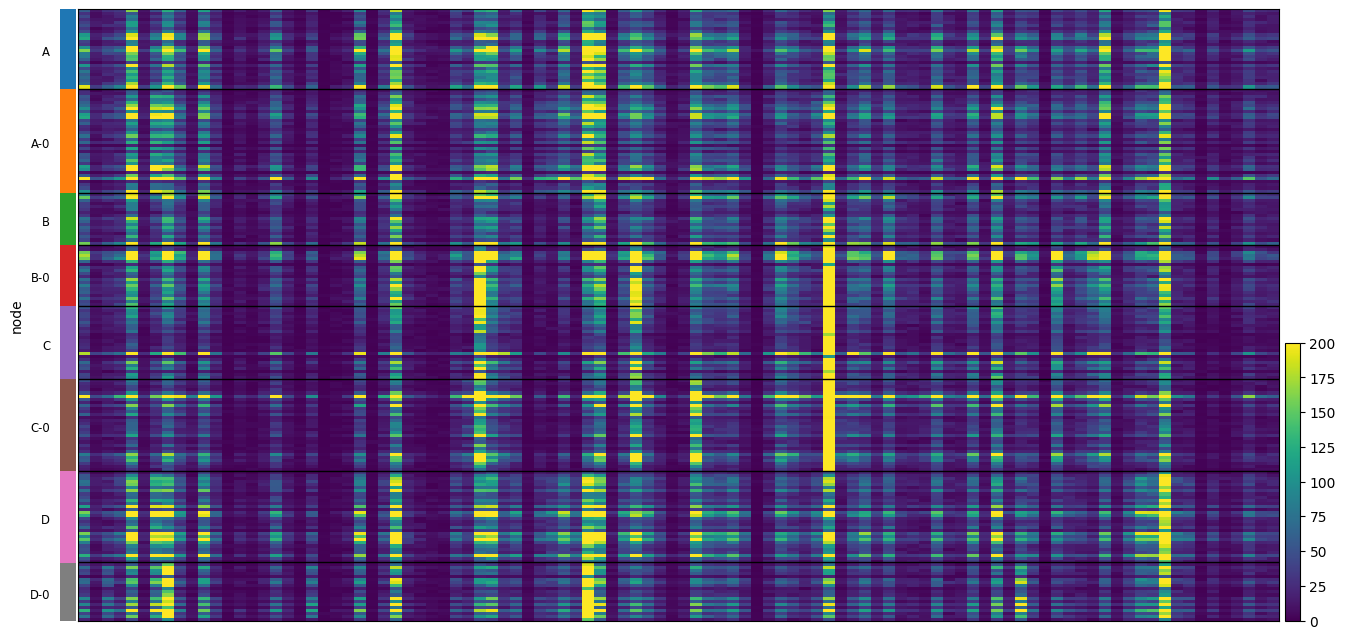

In [4]:
sc.pl.heatmap(sim_sca.adata, groupby='node', var_names=sim_sca.adata.var_names, vmax=200, use_raw=True,  figsize=(16,8))

... storing 'node' as categorical


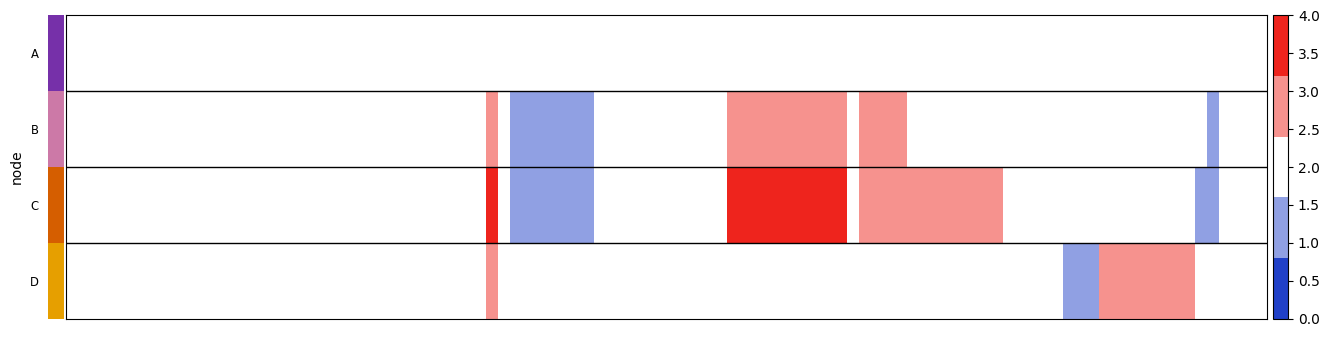

In [5]:
sim_sca.observed_tree.plot_heatmap(vmax=4, vmin=0, figsize=(16,4))

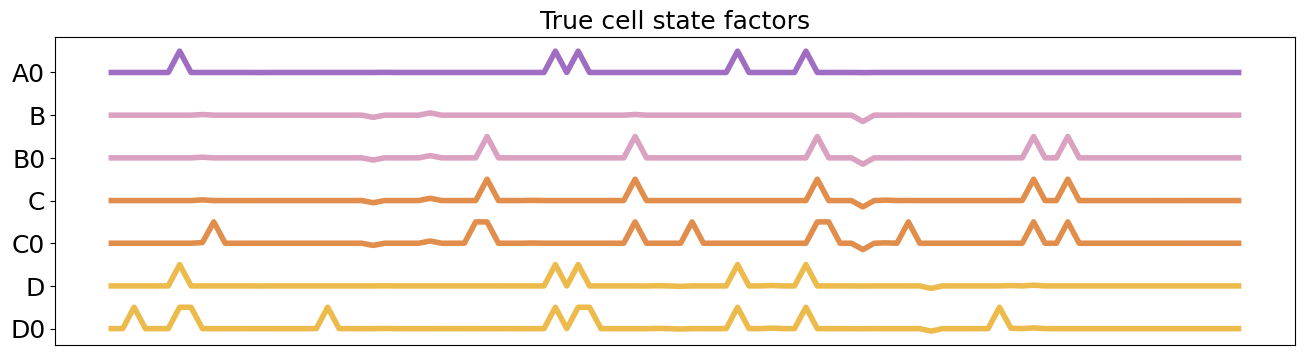

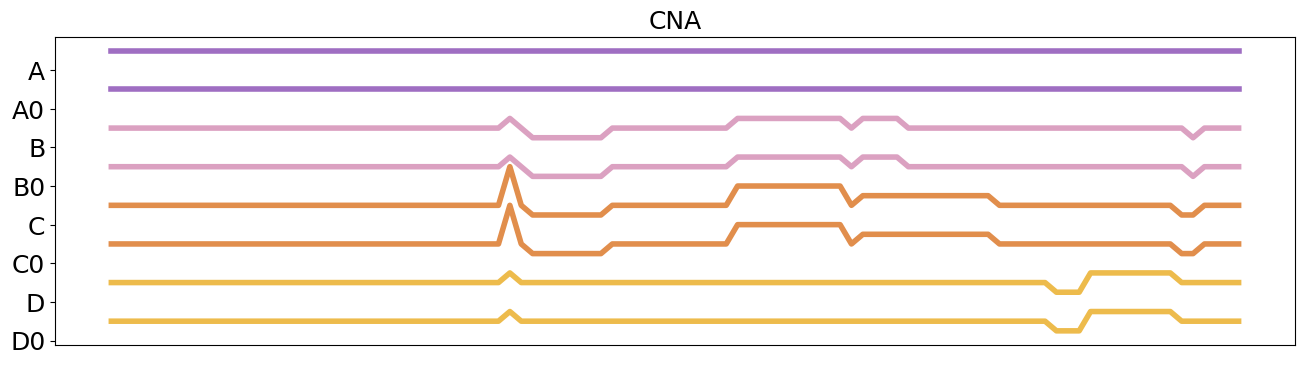

In [6]:
sim_sca.plot_unobserved_parameters(step=2.,estimated=False, title='True cell state factors', 
                               name='unobserved_factors',figsize=(16,4))
sim_sca.plot_observed_parameters(step=4., title='CNA', figsize=(16,4))

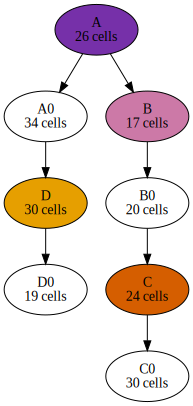

In [7]:
sim_sca.plot_tree(counts=True)

## Run SCATrEx

In [8]:
theta = 100
args = dict(num_global_noise_factors=0)
sca = scatrex.SCATrEx(model=models.cna, model_args=args)
sca.model_args = args
sca.add_data(sim_sca.adata.raw.to_adata())
sca.set_observed_tree(sim_sca.observed_tree)
sca.normalize_data()
sca.project_data()

search_kwargs = {'n_iters': 500, 'n_iters_elbo': 100,                
                'move_weights': move_weights,
                'local': True,
                'factor_delay': 0,
                'step_size': 0.01,
                'posterior_delay': 10,
                'mb_size': 200,
                'num_samples': 1,
                'max_nodes': 5,
                'add_rule_thres': 1.,
                'joint_init': True,
                'anneal': False,
                'restart_step': 100,
                'window': 50,
                'every': 10,
                'threshold': 1e-3,
                'alpha': 0.,
                'random_seed': 1}
sca.learn_tree(reset=True, search_kwargs=search_kwargs)

INFO:scatrex.scatrex:Normalized data are stored in `self.adata`
INFO:scatrex.scatrex:2-projected data are stored in `self.pca` and projection matrix in `self.pca_obj`
/Users/pedrof/opt/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


  0%|          | 0/500 [00:00<?, ?it/s]

/Users/pedrof/projects/SCATrEx/scatrex/ntssb/ntssb.py:445: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  weights.append(np.array(node_weights).ravel() * subtree_weights[i])


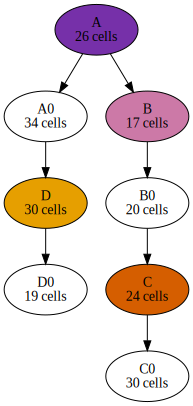

In [9]:
sca.ntssb.plot_tree(counts=True)

We can get an overview of the estimated cell state factors for each node in the augmented tree with the `plot_unobserved_parameters` function.

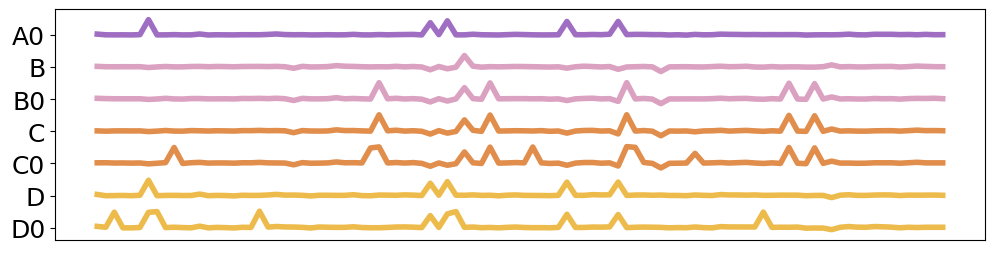

In [11]:
sca.plot_unobserved_parameters(estimated=True, figsize=(12,3), step=2)

To see whether cell state events occur in copy number regions, and whether they contradict them, we can use `plot_cnv_vs_state`. For example, we observe a contradicting event in node B in a gene with copy number 1. In general, this may suggest that that gene is not copy number sensitive, or that there was an focal event at that gene that contradicts the overall copy number in the region that contains that gene.

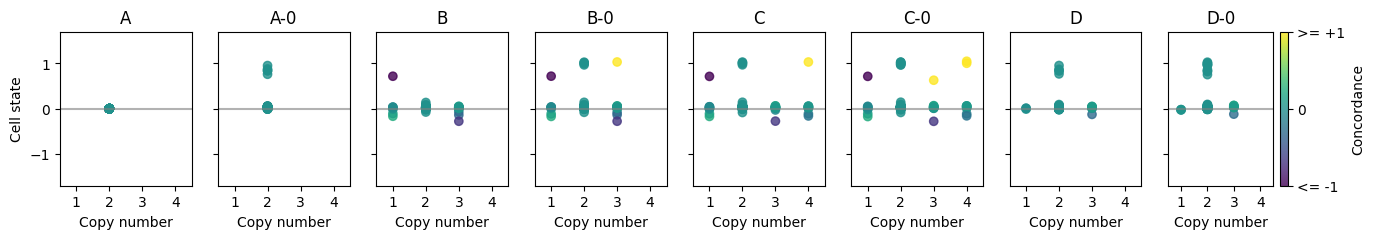

In [12]:
# Comparing the CNVs with the cell state factors at each node highlights non-dosage-sensitive genes
concordances = sca.get_concordances()
cnv_state = sca.get_cnv_vs_state()
nodes = sorted(list(cnv_state.keys()))

sca.plot_cnv_vs_state(nodes, mapping=cnv_state, 
                  state_range=[-1.5,1.5], figsize=(16,2), alpha=0.8, concordances=concordances)


Of course, here we are in a simulation setting, and we did simulate that 5% of genes are not dosage sensitive. We can plot the genes containing the most discordant cell state factors, rank them and color them by whether they are dosage sensitive or not.

In [13]:
is_dosage_sensitive = np.array([True] * 100)
is_dosage_sensitive[sim_sca.ntssb.root['node'].root['node'].inert_genes] = False

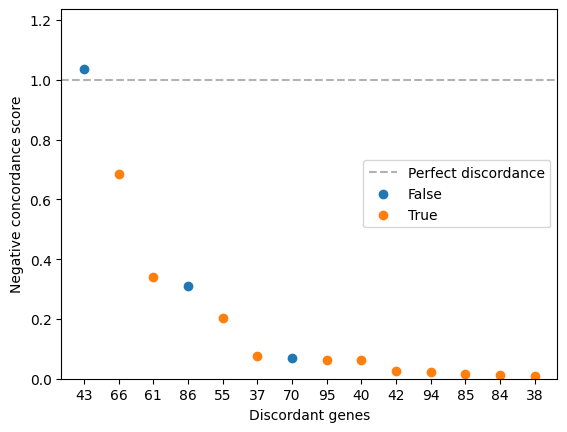

In [14]:
# We can also rank the most discordant events across the whole tree
sorted_discordant_genes, sorted_concordances, sorted_nodes  = sca.get_discordant_genes(concordances)
sca.plot_discordant_genes(sorted_discordant_genes, sorted_concordances, sorted_nodes=None, 
                          gene_annots=is_dosage_sensitive)

Genes 43 is indeed not dosage-sensitive, explains its high discordance score.

To see the cell state factor of a specific gene, we can either plot its variational distributions, or color the tree by its estimated value.

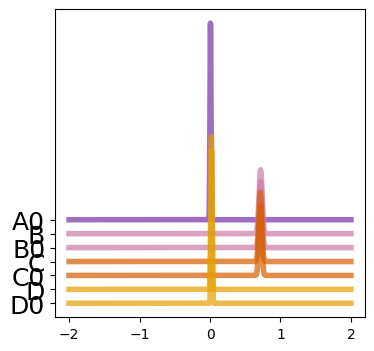

In [15]:
sca.plot_unobserved_parameters(estimated=True, gene='43', x_max=2)

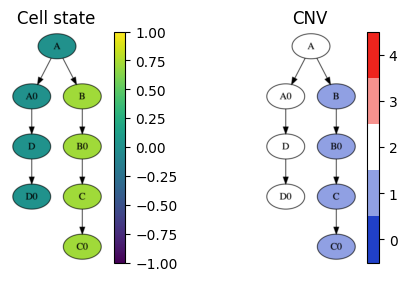

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(6,3))
sca.plot_tree(gene='43', genemode='unobserved', ax=axes[0], title='Cell state')
sca.plot_tree(gene='43', genemode='observed', ax=axes[1], title='CNV')
plt.show()

Finally, SCATrEx enables us to see how cell state events propagate across lineages. We can use `plot_state_inheritance_scores` to see the variational distribution of genes affected at the start of a lineage and how they change downstream. The heritability score indicates the probability of the cell state factor at a node being close to the value at the parent. This function only considers genes which are CNV-constant in the lineage.

In particular, this allows us to find genes whose cell state events are not inherited by their children nodes. This may be due to plasticity, for example, or violations of the infinite sites assumption the model uses (but doesn't enforce). 

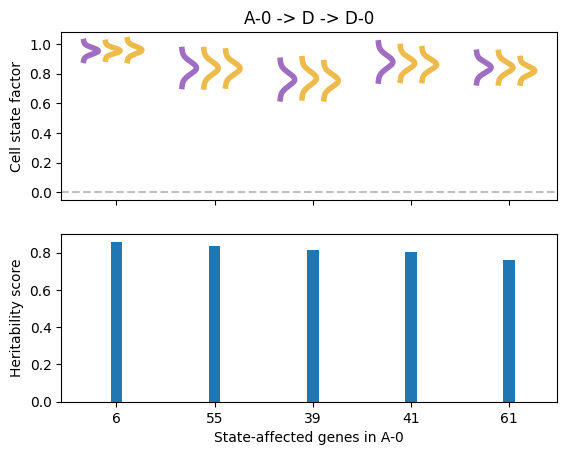

In [17]:
sca.plot_state_inheritance_scores(['A-0' ,'D', 'D-0'])

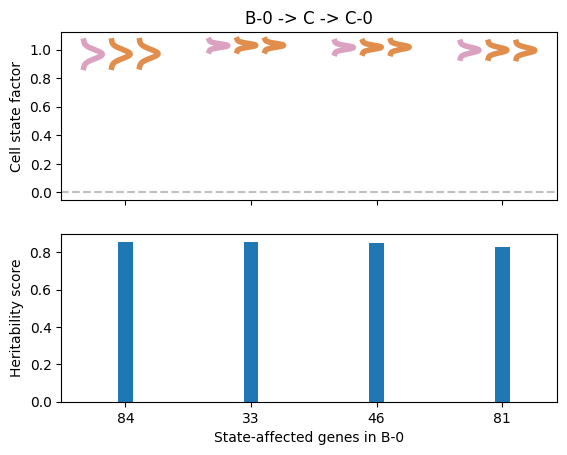

In [18]:
sca.plot_state_inheritance_scores(['B-0' ,'C', 'C-0'])